In [6]:
import anndata as ad
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
# import rapids_singlecell as rsc
import scanpy as sc
import seaborn as sns
from sklearn.cluster import MiniBatchKMeans

import sys
sys.path.append('/nfs/home/users/krakovic/sharedscratch/notebooks/latticea_he/libraries/')
from clinical import load_clinical
from data_processing import *


In [2]:
adata = ad.read_h5ad('/nfs/home/users/krakovic/sharedscratch/notebooks/latticea_he/codex/00_data/03_LUAD_markers_clustered_2p0_4slides_with_phenotypes.h5ad')
adata

AnnData object with n_obs × n_vars = 2670923 × 26
    obs: 'core_ID', 'CellX', 'CellY', 'TMA', 'samples', 'leiden_0.5', 'leiden_0.6', 'leiden_0.8', 'leiden_1.0', 'leiden_1.5', 'leiden_2.0', 'cell_lineage', 'immune_lineage'
    uns: 'TMA_colors', 'leiden', 'leiden_0.5_colors', 'leiden_0.6_colors', 'leiden_0.8_colors', 'leiden_1.0_colors', 'leiden_1.5_colors', 'leiden_2.0_colors', 'nn_leiden', 'umap'
    obsm: 'X_umap'
    obsp: 'nn_leiden_connectivities', 'nn_leiden_distances'

In [43]:
adata.var_names

Index(['CD105_z', 'CD31_z', 'FAP_z', 'CD20_z', 'CD68_z', 'CD38_z', 'CD45_z',
       'Podoplanin_z', 'GATA6_z', 'HLA-DR_z', 'COL1A_z', 'CA9_z', 'CD8_z',
       'SMA_z', 'DECORIN_z', 'ECAD_z', 'CD4_z', 'GREM1_z', 'COLIV_z', 'NCAD_z',
       'CKPAN_z', 'LIF_z', 'S100A4_z', 'Vimentin_z', 'IL6_z', 'HNF4A_z'],
      dtype='object')

In [44]:
adata_stroma = adata[adata.obs['cell_lineage'] == 'stroma']

stromal_markers = ['CD31_z', 'COLIV_z', 'LIF_z', 'FAP_z', 'SMA_z', 'HLA-DR_z', 'IL6_z', 'Vimentin_z', 'Podoplanin_z', 'DECORIN_z', 'COL1A_z', 'S100A4_z']
# stromal_markers = ['CD31_z', 'COLIV_z', 'NCAD_z', 'LIF_z', 'FAP_z', 'SMA_z', 'HLA-DR_z', 'IL6_z', 'Vimentin_z', 'Podoplanin_z', 'DECORIN_z', 'COL1A_z']

adata_stroma = adata_stroma[:, adata_stroma.var_names.isin(stromal_markers)]
adata_stroma.var_names = [var.split("_")[0] for var in adata_stroma.var_names]

adata_stroma

AnnData object with n_obs × n_vars = 595491 × 12
    obs: 'core_ID', 'CellX', 'CellY', 'TMA', 'samples', 'leiden_0.5', 'leiden_0.6', 'leiden_0.8', 'leiden_1.0', 'leiden_1.5', 'leiden_2.0', 'cell_lineage', 'immune_lineage'
    uns: 'TMA_colors', 'leiden', 'leiden_0.5_colors', 'leiden_0.6_colors', 'leiden_0.8_colors', 'leiden_1.0_colors', 'leiden_1.5_colors', 'leiden_2.0_colors', 'nn_leiden', 'umap'
    obsm: 'X_umap'
    obsp: 'nn_leiden_connectivities', 'nn_leiden_distances'

In [45]:
adata_stroma.var_names

Index(['CD31', 'FAP', 'Podoplanin', 'HLA-DR', 'COL1A', 'SMA', 'DECORIN',
       'COLIV', 'LIF', 'S100A4', 'Vimentin', 'IL6'],
      dtype='object')

In [53]:
rsc.pp.neighbors(adata_stroma, n_neighbors=20, metric='euclidean', key_added='nn_leiden', random_state=42)
rsc.tl.umap(adata_stroma, min_dist=0.5, spread=1.0, n_components=2, neighbors_key='nn_leiden')

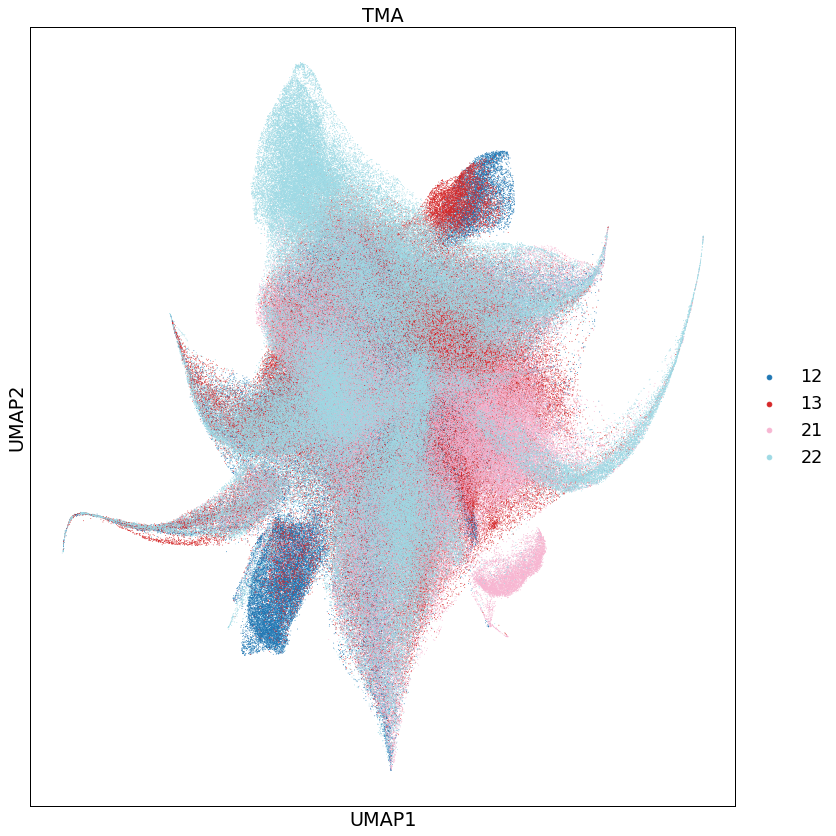

In [54]:
fig, ax = plt.subplots(figsize=(12,12))

sc.pl.umap(adata=adata_stroma, color='TMA', palette='tab20', size=3, ax=ax, show=False)

plt.tight_layout()
plt.show()

In [55]:
resolutions = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]

for resolution in resolutions:
    rsc.tl.leiden(adata=adata_stroma, resolution=resolution, key_added=f'stroma_leiden_{resolution}', neighbors_key='nn_leiden')


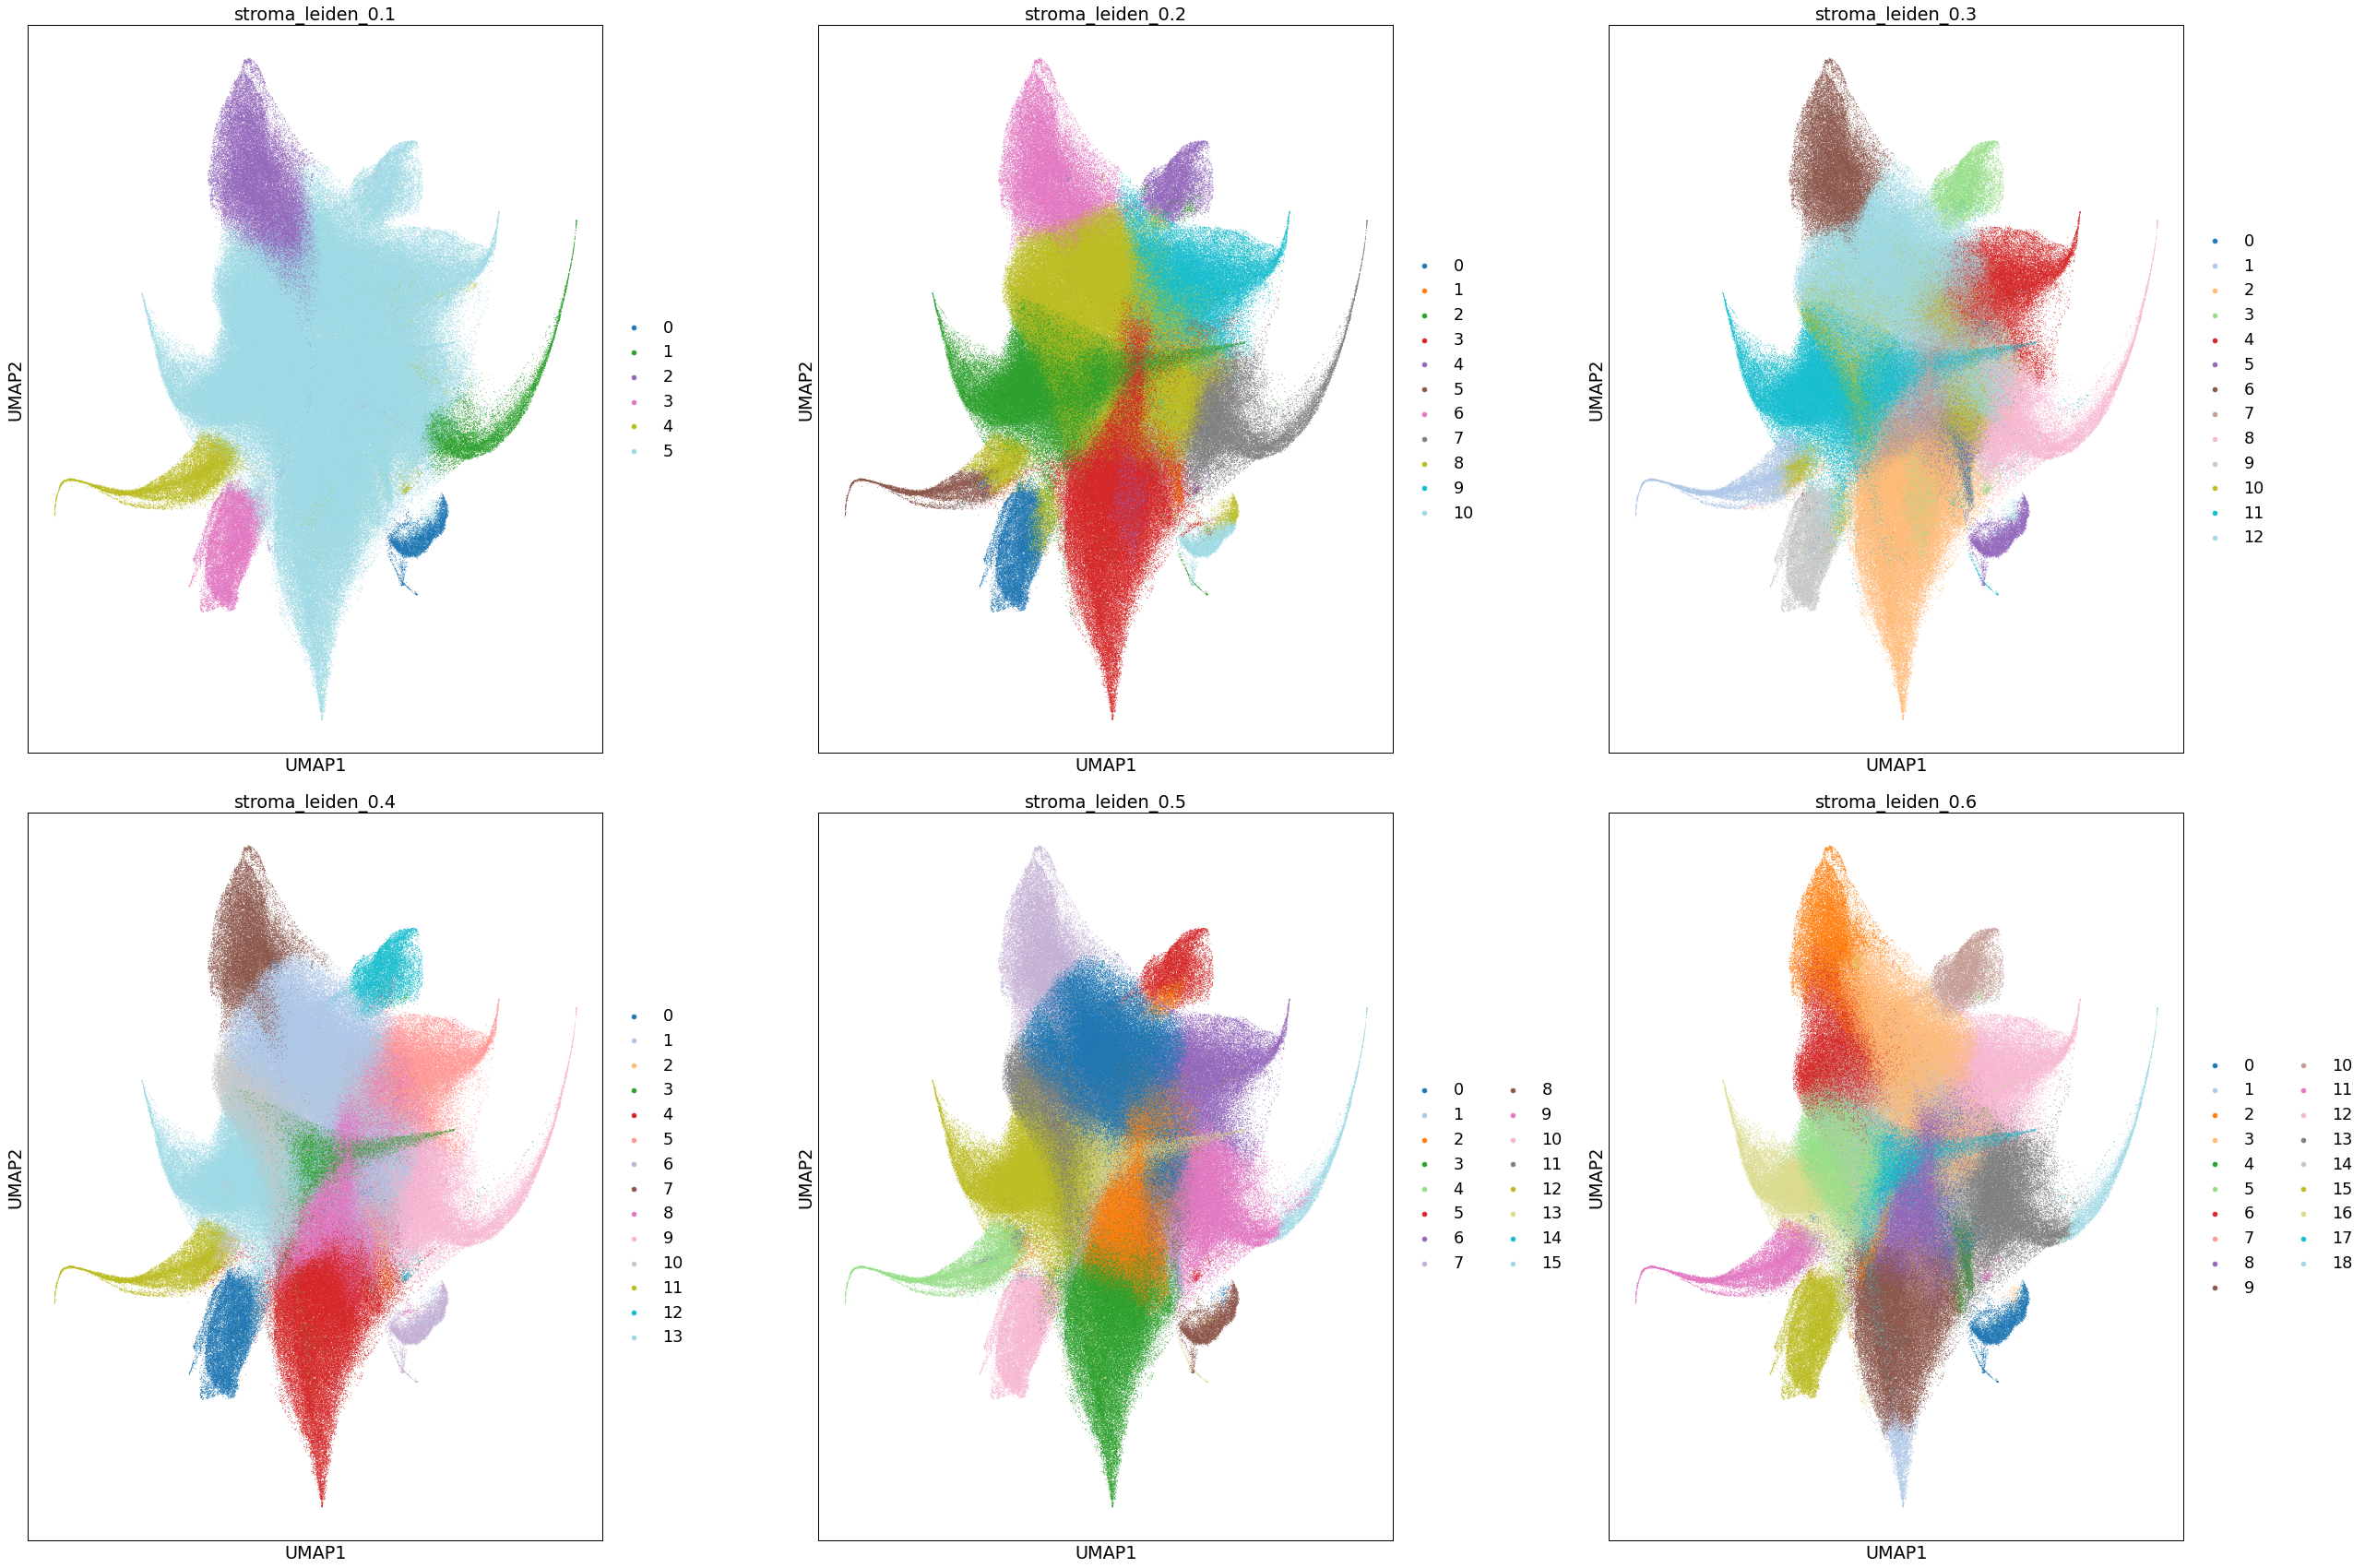

In [56]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(36,24))
axs = axs.flatten()

for i, resolution in enumerate(resolutions):
    sc.pl.umap(adata=adata_stroma, color=f'stroma_leiden_{resolution}', palette='tab20', size=3, ax=axs[i], show=False)

plt.tight_layout()
plt.show()

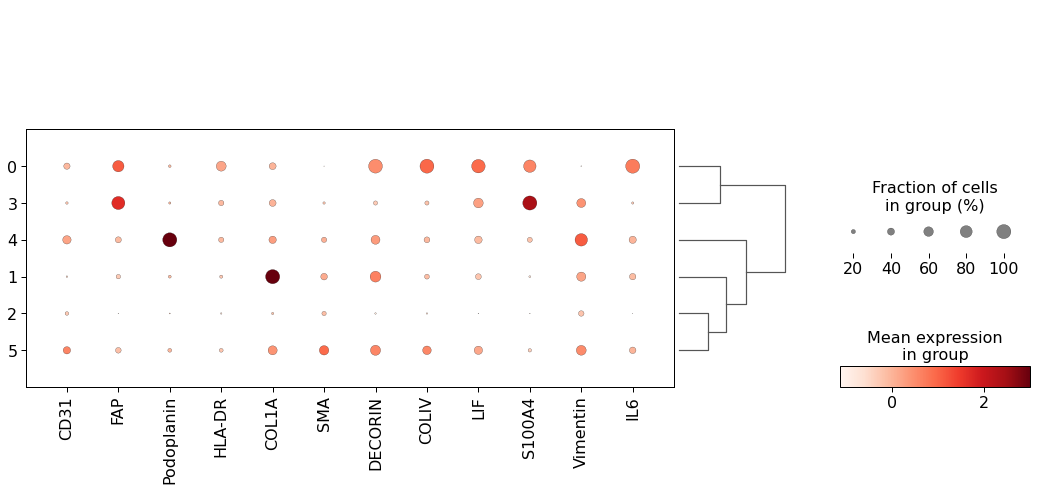

In [57]:
groupby = 'stroma_leiden_0.1'

sns.set_context("paper", font_scale=2.0)

sc.tl.dendrogram(adata=adata_stroma, groupby=groupby)
fig, ax = plt.subplots(figsize=(18,7))
sc.pl.dotplot(adata_stroma, var_names=adata_stroma.var_names, groupby=groupby, dendrogram=True, ax=ax, vmax=3)

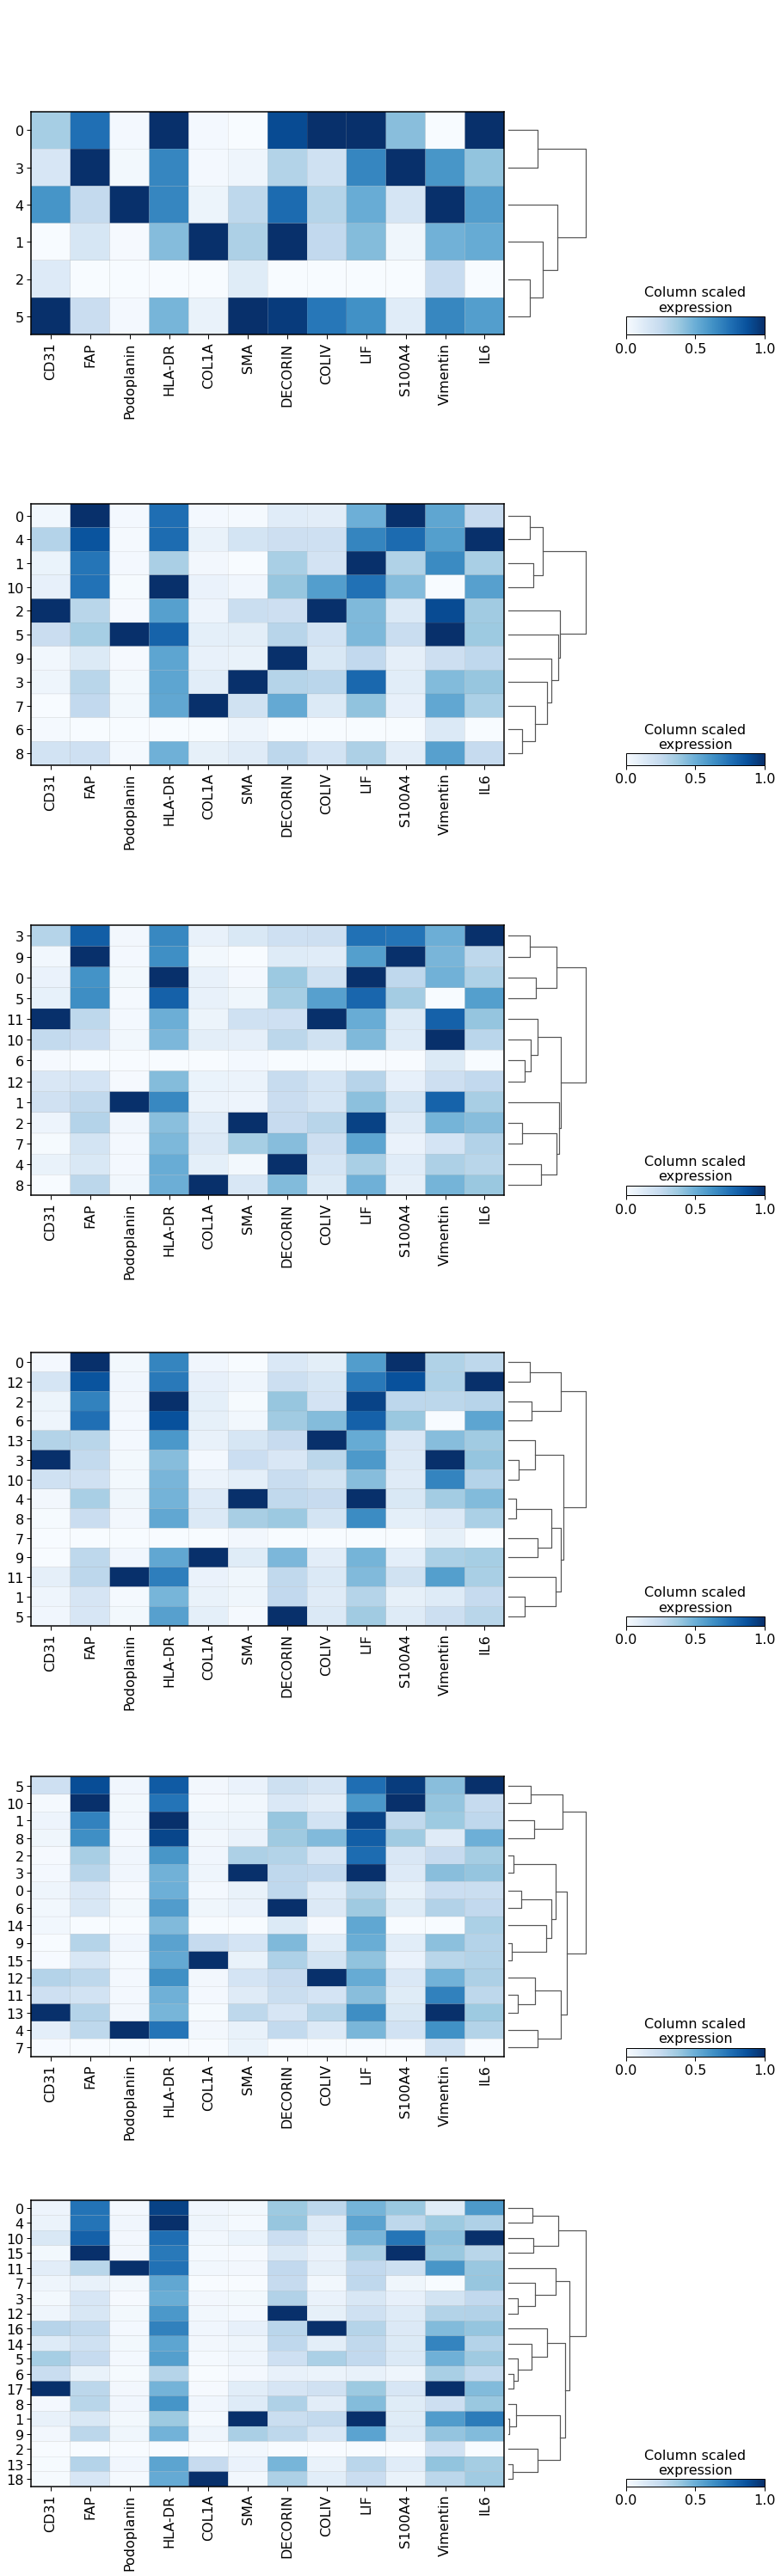

In [58]:
fig, axs = plt.subplots(nrows=6, ncols=1, figsize=(13,7*6))
axs = axs.flatten()

for i, resolution in enumerate(resolutions):
    groupby = f'stroma_leiden_{resolution}'
    sc.tl.dendrogram(adata=adata_stroma, groupby=groupby)
    sc.pl.matrixplot(adata_stroma, var_names=adata_stroma.var_names, groupby=groupby, dendrogram=True, cmap='Blues', vmin=0, vmax=1, standard_scale='var', colorbar_title="Column scaled\nexpression", show=False, ax=axs[i])
# sc.pl.matrixplot(adata_stroma, var_names=adata_stroma.var_names, groupby='stroma_leiden_0.5', dendrogram=True, cmap='Blues', standard_scale='var', colorbar_title="Column scaled\nexpression", figsize=(13,7))

plt.tight_layout()
plt.show()

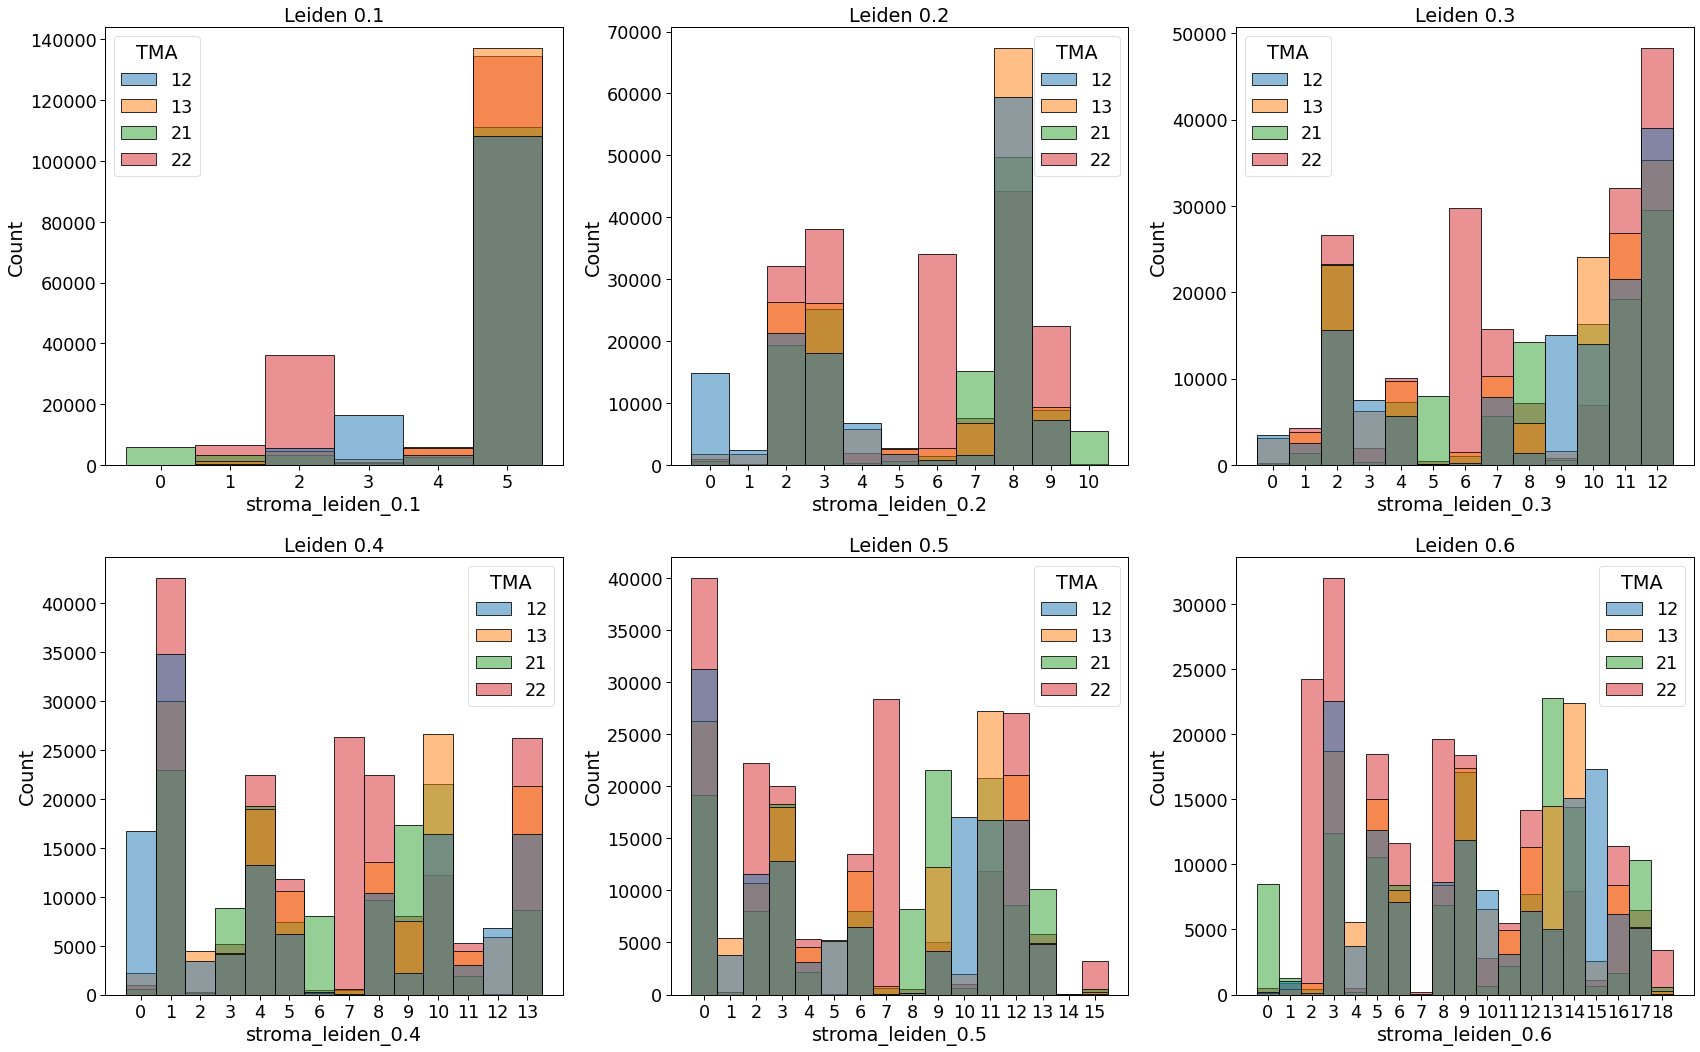

In [59]:
# CLuster frequency on TMAs -- are some TMA specific? Not really, but some predominance. 
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(24,15))
axs = axs.flatten()
for i, resolution in enumerate(resolutions):
    sns.histplot(data=adata_stroma.obs, x=f'stroma_leiden_{resolution}', hue='TMA', ax=axs[i])
    axs[i].set_title(f'Leiden {resolution}')

plt.tight_layout()
plt.show()

In [ ]:

kmeans = MiniBatchKMeans(n_clusters=6, random_state=0)
adata_stroma.obs['kmeans'] = kmeans.fit_predict(X=adata_stroma.X)
adata_stroma.obs

core_ID    CellX    CellY TMA   samples leiden_0.5 leiden_0.6  \
cell_0        12-15-J   2396.8   6263.1  12  ACA_0662         21         26   
cell_16       12-15-J   2576.0   6276.9  12  ACA_0662         21         26   
cell_23       12-15-J   2384.6   6281.8  12  ACA_0662         21         26   
cell_32       12-15-J   2508.0   6289.9  12  ACA_0662         21         26   
cell_36       12-15-J   2392.0   6290.7  12  ACA_0662         21         26   
...               ...      ...      ...  ..       ...        ...        ...   
cell_2670889  22-15-J  17466.5  21102.6  22  ACA_1069         21         26   
cell_2670895  22-15-J  17132.9  20327.1  22  ACA_1069         46         55   
cell_2670899  22-15-J  16799.7  20627.6  22  ACA_1069         21         26   
cell_2670903  22-15-J  17811.9  20821.9  22  ACA_1069         46         55   
cell_2670920  22-15-J  17500.8  20961.7  22  ACA_1069         26         15   

             leiden_0.8 leiden_1.0 leiden_1.5 leiden_2.0 cell_lineage  \
cell_0               25         31         45         56       stroma   
cell_16              25         31         45         85       stroma   
cell_23              25         31         45         56       stroma   
cell_32              25         31         45         56       stroma   
cell_36              25         31         45         56       stroma   
...                 ...        ...        ...        ...          ...   
cell_2670889         25         31         65         85       stroma   
cell_2670895         28         74         97         23       stroma   
cell_2670899         25         31         45         56       stroma   
cell_2670903         33         74         97         23       stroma   
cell_2670920         33         45         10         12       stroma   

             immune_lineage stroma_leiden_0.1 stroma_leiden_0.2  \
cell_0                  NaN                 5                 8   
cell_16                 NaN                 5                 2   
cell_23                 NaN                 5                 8   
cell_32                 NaN                 5                 2   
cell_36                 NaN                 5                 8   
...                     ...               ...               ...   
cell_2670889            NaN                 5                 3   
cell_2670895            NaN                 2                 6   
cell_2670899            NaN                 5                 2   
cell_2670903            NaN                 2                 6   
cell_2670920            NaN                 5                 9   

             stroma_leiden_0.3 stroma_leiden_0.4 stroma_leiden_0.5  \
cell_0                      12                 1                 0   
cell_16                      2                 4                 3   
cell_23                     11                13                12   
cell_32                     11                 3                13   
cell_36                     12                10                11   
...                        ...               ...               ...   
cell_2670889                 2                 4                 3   
cell_2670895                 6                 7                 7   
cell_2670899                11                13                12   
cell_2670903                 6                 7                 7   
cell_2670920                 7                 8                 6   

             stroma_leiden_0.6  kmeans  
cell_0                       6       1  
cell_16                      9       2  
cell_23                      5       2  
cell_32                     17       0  
cell_36                      5       1  
...                        ...     ...  
cell_2670889                17       2  
cell_2670895                 2       1  
cell_2670899                17       0  
cell_2670903                 2       1  
cell_2670920                12       1  

[595491 rows x 20 columns]

In [44]:
# Review on QuPath
adata_stroma.obs[adata_stroma.obs['TMA'] == '22'][['CellX', 'CellY', 'stroma_leiden_0.5']].to_csv('/nfs/home/users/krakovic/sharedscratch/notebooks/latticea_he/codex/02_analysis/tma_22_stromal_clusters.csv')

In [278]:
# adata_stroma.write_h5ad('/nfs/home/users/krakovic/sharedscratch/notebooks/latticea_he/codex/00_data/04_adata_stroma_clustered_0p1-0p6.h5ad')
adata_stroma.write_h5ad('/nfs/home/users/krakovic/sharedscratch/notebooks/latticea_he/codex/00_data/04_adata_stroma_clustered_0p1-0p6_kmeans.h5ad')

In [3]:
adata_stroma = ad.read_h5ad('/nfs/home/users/krakovic/sharedscratch/notebooks/latticea_he/codex/00_data/04_adata_stroma_clustered_0p1-0p6_kmeans.h5ad')
adata_stroma.obs

core_ID    CellX    CellY TMA   samples leiden_0.5 leiden_0.6  \
cell_0        12-15-J   2396.8   6263.1  12  ACA_0662         21         26   
cell_16       12-15-J   2576.0   6276.9  12  ACA_0662         21         26   
cell_23       12-15-J   2384.6   6281.8  12  ACA_0662         21         26   
cell_32       12-15-J   2508.0   6289.9  12  ACA_0662         21         26   
cell_36       12-15-J   2392.0   6290.7  12  ACA_0662         21         26   
...               ...      ...      ...  ..       ...        ...        ...   
cell_2670889  22-15-J  17466.5  21102.6  22  ACA_1069         21         26   
cell_2670895  22-15-J  17132.9  20327.1  22  ACA_1069         46         55   
cell_2670899  22-15-J  16799.7  20627.6  22  ACA_1069         21         26   
cell_2670903  22-15-J  17811.9  20821.9  22  ACA_1069         46         55   
cell_2670920  22-15-J  17500.8  20961.7  22  ACA_1069         26         15   

             leiden_0.8 leiden_1.0 leiden_1.5 leiden_2.0 cell_lineage  \
cell_0               25         31         45         56       stroma   
cell_16              25         31         45         85       stroma   
cell_23              25         31         45         56       stroma   
cell_32              25         31         45         56       stroma   
cell_36              25         31         45         56       stroma   
...                 ...        ...        ...        ...          ...   
cell_2670889         25         31         65         85       stroma   
cell_2670895         28         74         97         23       stroma   
cell_2670899         25         31         45         56       stroma   
cell_2670903         33         74         97         23       stroma   
cell_2670920         33         45         10         12       stroma   

             immune_lineage stroma_leiden_0.1 stroma_leiden_0.2  \
cell_0                  NaN                 5                 8   
cell_16                 NaN                 5                 2   
cell_23                 NaN                 5                 8   
cell_32                 NaN                 5                 2   
cell_36                 NaN                 5                 8   
...                     ...               ...               ...   
cell_2670889            NaN                 5                 3   
cell_2670895            NaN                 2                 6   
cell_2670899            NaN                 5                 2   
cell_2670903            NaN                 2                 6   
cell_2670920            NaN                 5                 9   

             stroma_leiden_0.3 stroma_leiden_0.4 stroma_leiden_0.5  \
cell_0                      12                 1                 0   
cell_16                      2                 4                 3   
cell_23                     11                13                12   
cell_32                     11                 3                13   
cell_36                     12                10                11   
...                        ...               ...               ...   
cell_2670889                 2                 4                 3   
cell_2670895                 6                 7                 7   
cell_2670899                11                13                12   
cell_2670903                 6                 7                 7   
cell_2670920                 7                 8                 6   

             stroma_leiden_0.6 kmeans  
cell_0                       6      1  
cell_16                      9      2  
cell_23                      5      2  
cell_32                     17      0  
cell_36                      5      1  
...                        ...    ...  
cell_2670889                17      2  
cell_2670895                 2      1  
cell_2670899                17      0  
cell_2670903                 2      1  
cell_2670920                12      1  

[595491 rows x 20 columns]

In [4]:
adata_stroma.obs

core_ID    CellX    CellY TMA   samples leiden_0.5 leiden_0.6  \
cell_0        12-15-J   2396.8   6263.1  12  ACA_0662         21         26   
cell_16       12-15-J   2576.0   6276.9  12  ACA_0662         21         26   
cell_23       12-15-J   2384.6   6281.8  12  ACA_0662         21         26   
cell_32       12-15-J   2508.0   6289.9  12  ACA_0662         21         26   
cell_36       12-15-J   2392.0   6290.7  12  ACA_0662         21         26   
...               ...      ...      ...  ..       ...        ...        ...   
cell_2670889  22-15-J  17466.5  21102.6  22  ACA_1069         21         26   
cell_2670895  22-15-J  17132.9  20327.1  22  ACA_1069         46         55   
cell_2670899  22-15-J  16799.7  20627.6  22  ACA_1069         21         26   
cell_2670903  22-15-J  17811.9  20821.9  22  ACA_1069         46         55   
cell_2670920  22-15-J  17500.8  20961.7  22  ACA_1069         26         15   

             leiden_0.8 leiden_1.0 leiden_1.5 leiden_2.0 cell_lineage  \
cell_0               25         31         45         56       stroma   
cell_16              25         31         45         85       stroma   
cell_23              25         31         45         56       stroma   
cell_32              25         31         45         56       stroma   
cell_36              25         31         45         56       stroma   
...                 ...        ...        ...        ...          ...   
cell_2670889         25         31         65         85       stroma   
cell_2670895         28         74         97         23       stroma   
cell_2670899         25         31         45         56       stroma   
cell_2670903         33         74         97         23       stroma   
cell_2670920         33         45         10         12       stroma   

             immune_lineage stroma_leiden_0.1 stroma_leiden_0.2  \
cell_0                  NaN                 5                 8   
cell_16                 NaN                 5                 2   
cell_23                 NaN                 5                 8   
cell_32                 NaN                 5                 2   
cell_36                 NaN                 5                 8   
...                     ...               ...               ...   
cell_2670889            NaN                 5                 3   
cell_2670895            NaN                 2                 6   
cell_2670899            NaN                 5                 2   
cell_2670903            NaN                 2                 6   
cell_2670920            NaN                 5                 9   

             stroma_leiden_0.3 stroma_leiden_0.4 stroma_leiden_0.5  \
cell_0                      12                 1                 0   
cell_16                      2                 4                 3   
cell_23                     11                13                12   
cell_32                     11                 3                13   
cell_36                     12                10                11   
...                        ...               ...               ...   
cell_2670889                 2                 4                 3   
cell_2670895                 6                 7                 7   
cell_2670899                11                13                12   
cell_2670903                 6                 7                 7   
cell_2670920                 7                 8                 6   

             stroma_leiden_0.6 kmeans  
cell_0                       6      1  
cell_16                      9      2  
cell_23                      5      2  
cell_32                     17      0  
cell_36                      5      1  
...                        ...    ...  
cell_2670889                17      2  
cell_2670895                 2      1  
cell_2670899                17      0  
cell_2670903                 2      1  
cell_2670920                12      1  

[595491 rows x 20 columns]

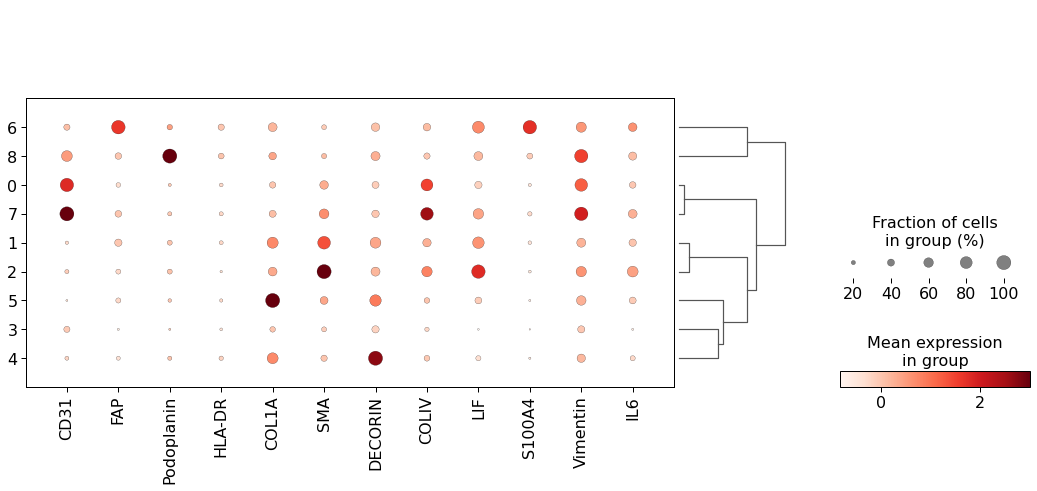

In [8]:
sns.set_context("paper", font_scale=2.0)

n_clusters = 9
kmeans = MiniBatchKMeans(n_clusters=n_clusters, random_state=0)
groupby = f'kmeans_{n_clusters}'

adata_stroma.obs[groupby] = kmeans.fit_predict(X=adata_stroma.X)
adata_stroma.obs

adata_stroma.obs[groupby] = adata_stroma.obs[groupby].astype('category')


sc.tl.dendrogram(adata=adata_stroma, groupby=groupby)
fig, ax = plt.subplots(figsize=(18,7))
sc.pl.dotplot(adata_stroma, var_names=adata_stroma.var_names, groupby=groupby, dendrogram=True, ax=ax, vmax=3)

In [9]:
adata_stroma.obs['kmeans_9'].value_counts()

3    160192
1    141579
0     90097
4     77479
6     47500
2     34818
7     29266
5     11297
8      3263
Name: kmeans_9, dtype: int64

In [10]:
# CLusters 0 and 7 on kmeans k = 8 and k = 9 are the same cells, not meaningful so collapse these

adata_stroma.obs['kmeans_9'] = adata_stroma.obs['kmeans_9'].replace({7:0})
adata_stroma.obs['kmeans_9'].value_counts()

3    160192
1    141579
0    119363
4     77479
6     47500
2     34818
5     11297
8      3263
Name: kmeans_9, dtype: int64

In [11]:
# fibroblast_phenotype_dict = {0:'Endothelium', 1:'Fibroblast 1', 2:'Fibroblast 2', 3:'Fibroblast 3', 4:'Fibroblast 4', 5:'Fibrpblast 5', 6:'Fibroblast 6', 8:'Fibroblast 7'}
# fibroblast_phenotype_dict = {0:'Endothelium', 1:u'F\u2081', 2:'F\u2082', 3:'F\u2083', 4:'F\u2084', 5:'F\u2085', 6:'F\u2086', 8:'F\u2087'}
fibroblast_phenotype_dict = {0:'Endothelium', 1:r'$SMA_{med}COL1A_{med}$', 2:r'$SMA_{high}LIF_{high}$', 3:'Unclassifiable', 
                             4:r'$DCN_{high}COL1A_{med}$', 5:r'$COL1A_{high}DCN_{med}$', 6:r'$S100A4_{high}FAP_{high}$', 8:r'$PDPN_{high}$'}

adata_stroma.obs['text_phenotype'] = adata_stroma.obs[groupby].map(fibroblast_phenotype_dict)
adata_stroma.obs

core_ID    CellX    CellY TMA   samples leiden_0.5 leiden_0.6  \
cell_0        12-15-J   2396.8   6263.1  12  ACA_0662         21         26   
cell_16       12-15-J   2576.0   6276.9  12  ACA_0662         21         26   
cell_23       12-15-J   2384.6   6281.8  12  ACA_0662         21         26   
cell_32       12-15-J   2508.0   6289.9  12  ACA_0662         21         26   
cell_36       12-15-J   2392.0   6290.7  12  ACA_0662         21         26   
...               ...      ...      ...  ..       ...        ...        ...   
cell_2670889  22-15-J  17466.5  21102.6  22  ACA_1069         21         26   
cell_2670895  22-15-J  17132.9  20327.1  22  ACA_1069         46         55   
cell_2670899  22-15-J  16799.7  20627.6  22  ACA_1069         21         26   
cell_2670903  22-15-J  17811.9  20821.9  22  ACA_1069         46         55   
cell_2670920  22-15-J  17500.8  20961.7  22  ACA_1069         26         15   

             leiden_0.8 leiden_1.0 leiden_1.5  ... immune_lineage  \
cell_0               25         31         45  ...            NaN   
cell_16              25         31         45  ...            NaN   
cell_23              25         31         45  ...            NaN   
cell_32              25         31         45  ...            NaN   
cell_36              25         31         45  ...            NaN   
...                 ...        ...        ...  ...            ...   
cell_2670889         25         31         65  ...            NaN   
cell_2670895         28         74         97  ...            NaN   
cell_2670899         25         31         45  ...            NaN   
cell_2670903         33         74         97  ...            NaN   
cell_2670920         33         45         10  ...            NaN   

             stroma_leiden_0.1 stroma_leiden_0.2 stroma_leiden_0.3  \
cell_0                       5                 8                12   
cell_16                      5                 2                 2   
cell_23                      5                 8                11   
cell_32                      5                 2                11   
cell_36                      5                 8                12   
...                        ...               ...               ...   
cell_2670889                 5                 3                 2   
cell_2670895                 2                 6                 6   
cell_2670899                 5                 2                11   
cell_2670903                 2                 6                 6   
cell_2670920                 5                 9                 7   

             stroma_leiden_0.4 stroma_leiden_0.5 stroma_leiden_0.6 kmeans  \
cell_0                       1                 0                 6      1   
cell_16                      4                 3                 9      2   
cell_23                     13                12                 5      2   
cell_32                      3                13                17      0   
cell_36                     10                11                 5      1   
...                        ...               ...               ...    ...   
cell_2670889                 4                 3                17      2   
cell_2670895                 7                 7                 2      1   
cell_2670899                13                12                17      0   
cell_2670903                 7                 7                 2      1   
cell_2670920                 8                 6                12      1   

             kmeans_9           text_phenotype  
cell_0              3           Unclassifiable  
cell_16             2   $SMA_{high}LIF_{high}$  
cell_23             1   $SMA_{med}COL1A_{med}$  
cell_32             0              Endothelium  
cell_36             0              Endothelium  
...               ...                      ...  
cell_2670889        2   $SMA_{high}LIF_{high}$  
cell_2670895        3           Unclassifiable  
cell_2670899        0        

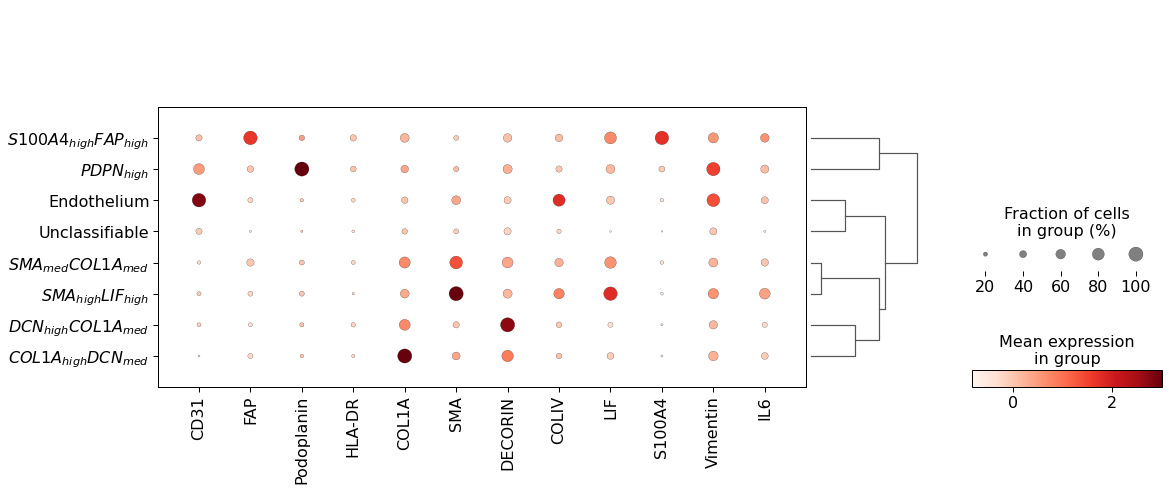

In [12]:
sc.tl.dendrogram(adata=adata_stroma, groupby='text_phenotype')
fig, ax = plt.subplots(figsize=(18,7))
sc.pl.dotplot(adata_stroma, var_names=adata_stroma.var_names, groupby='text_phenotype', dendrogram=True, ax=ax, vmax=3)

In [13]:
adata_stroma.obs_names = [f'Cell_{i}' for i in range(len(adata_stroma.obs_names))]
adata_stroma = adata_stroma[adata_stroma.obs['text_phenotype'] != 'Unclassifiable']

In [14]:
adata_stroma.obs[groupby].value_counts()

1    141579
0    119363
4     77479
6     47500
2     34818
5     11297
8      3263
Name: kmeans_9, dtype: int64

/mnt/cephfs/home/users/krakovic/.conda/envs/scpy/lib/python3.10/site-packages/scanpy/tools/_dendrogram.py:190: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = dat


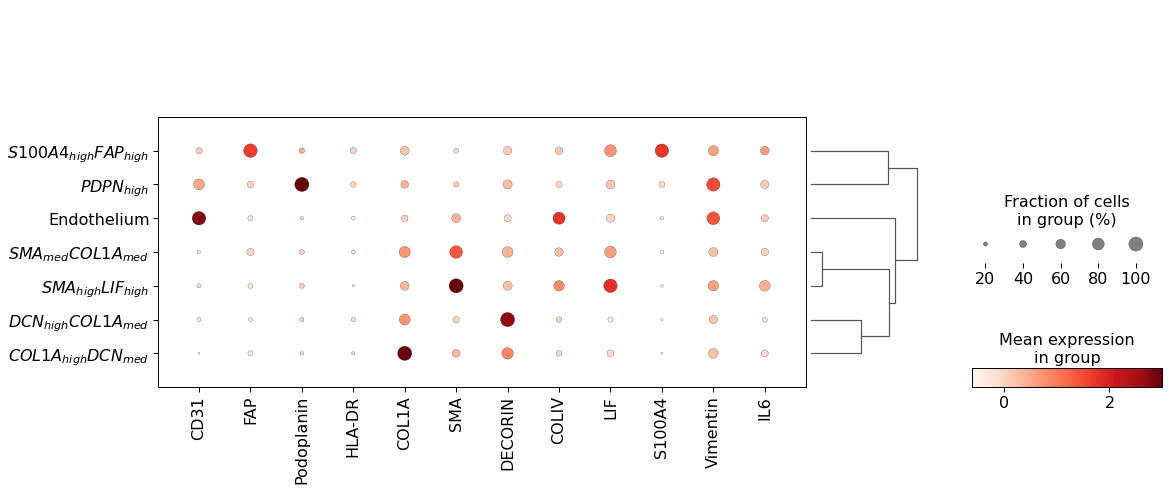

In [15]:
sc.tl.dendrogram(adata=adata_stroma, groupby='text_phenotype')
fig, ax = plt.subplots(figsize=(18,7))
sc.pl.dotplot(adata_stroma, var_names=adata_stroma.var_names, groupby='text_phenotype', dendrogram=True, ax=ax, vmax=3)

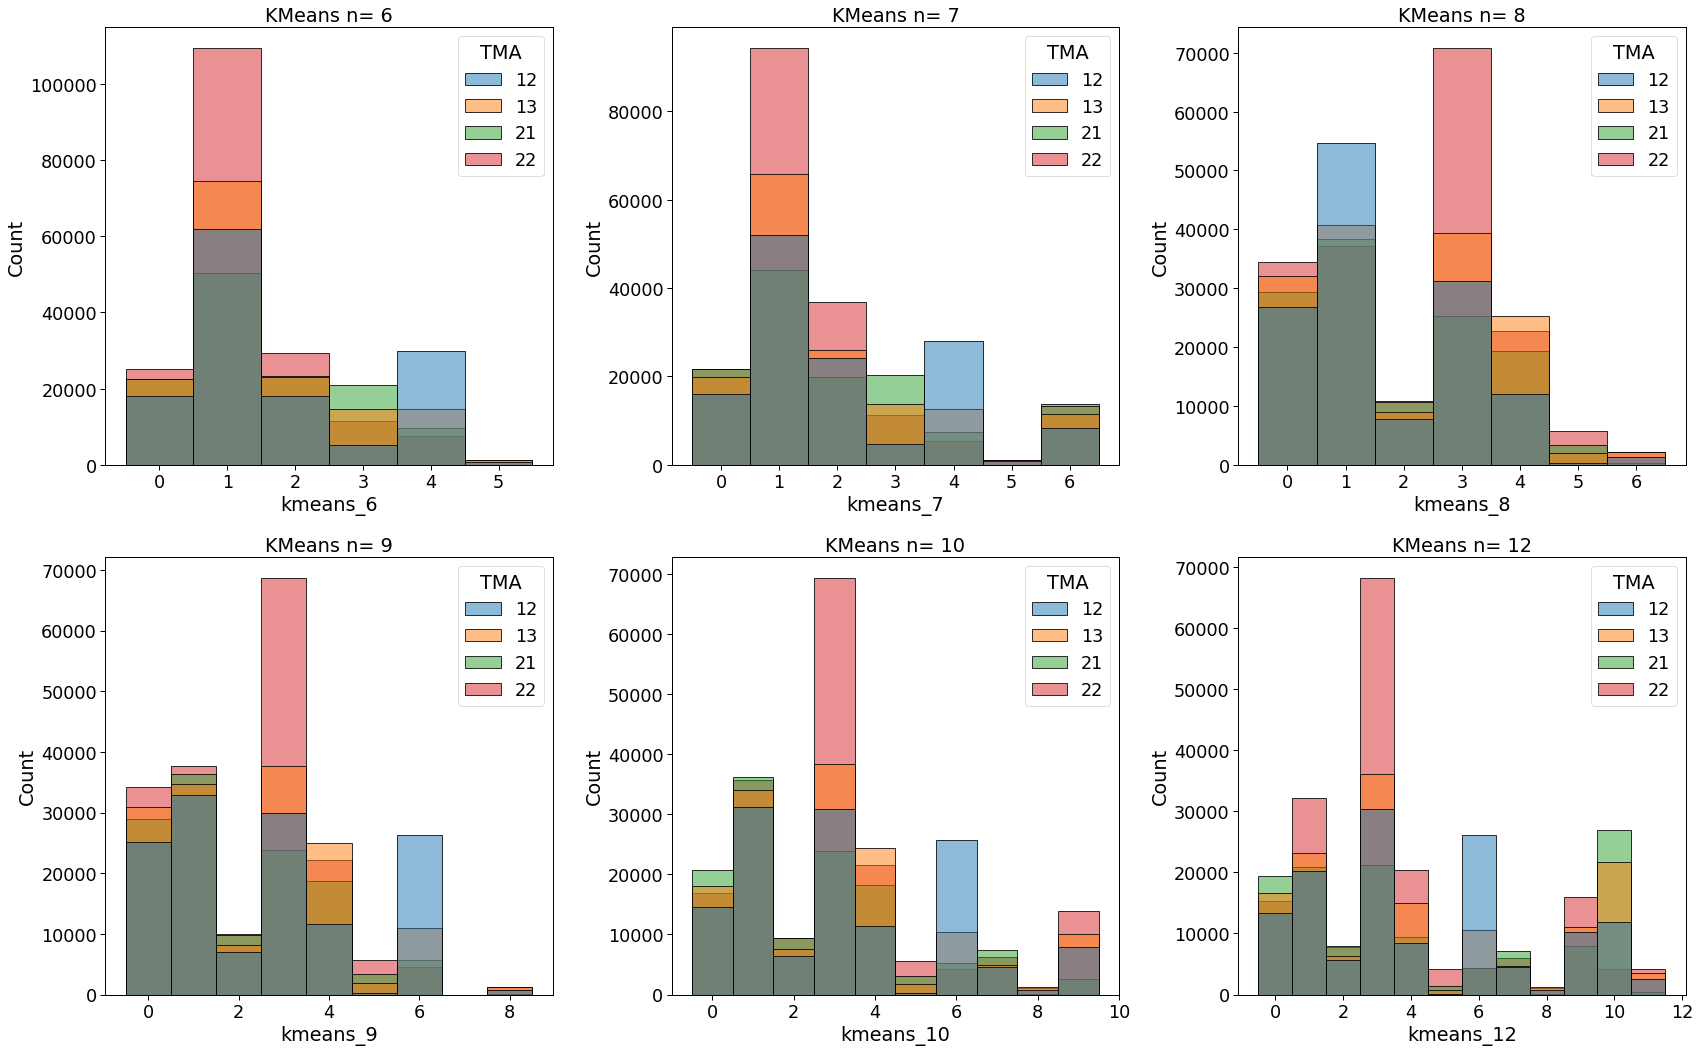

In [313]:
# CLuster frequency on TMAs -- are some TMA specific? Not really, but some predominance. 
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(24,15))
axs = axs.flatten()
for i, resolution in enumerate([6, 7, 8, 9, 10, 12]):
    sns.histplot(data=adata_stroma.obs, x=f'kmeans_{resolution}', hue='TMA', ax=axs[i])
    axs[i].set_title(f'KMeans n= {resolution}')

plt.tight_layout()
plt.show()

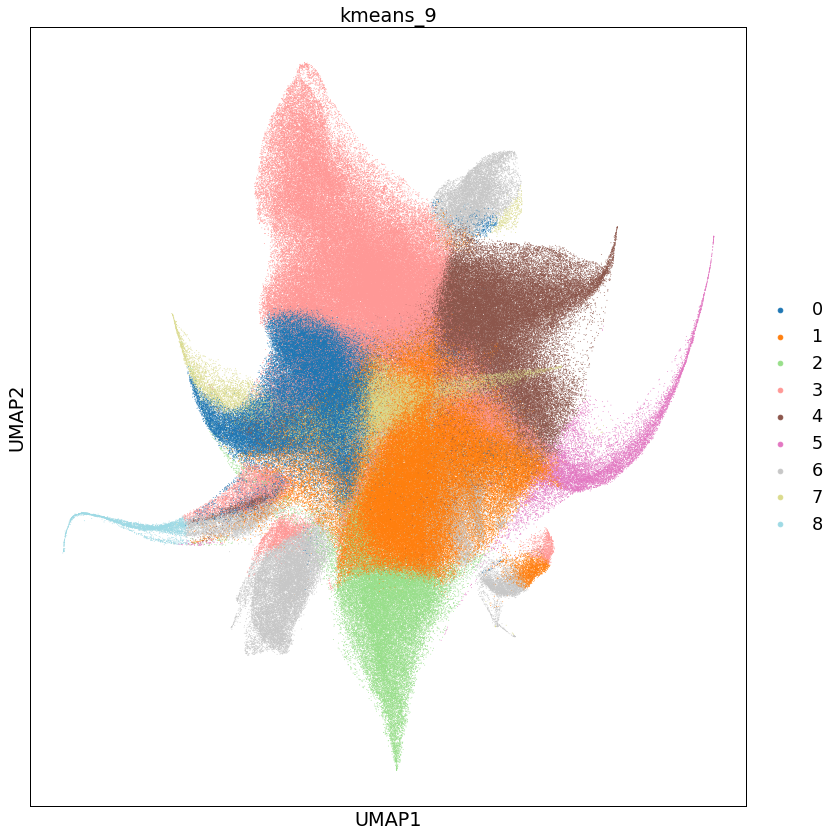

In [40]:
fig, ax = plt.subplots(figsize=(12,12))

sc.pl.umap(adata=adata_stroma, color=groupby, palette='tab20', size=3, ax=ax, show=False)

plt.tight_layout()
plt.show()

In [124]:
adata_stroma.write_h5ad('/nfs/home/users/krakovic/sharedscratch/notebooks/latticea_he/codex/00_data/04_adata_stroma_clustered_kmeans_9_withtext.h5ad')